# Synchronous States in Homogeneous Populations of LIF Neurons
### NX-465 Mini-project MP2
### Spring semester 2023

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Simulation parameters
tau_m = 10 #ms
v0 = -50.0  #mV
eta = 0 #mV
v_rest = 15 #mV
R = 50 #membrane resistance 50 Ohm
Beta = 1e2 #ms-1
Beta

100.0

## Exercise 0: Getting Started: non-interacting population

1. Consider N = 100 non-interacting neurons, with initial voltages vi(t = 0) uniformly distributed at random between v0 and η (i.e. vi(0) ∼ U([v0, η])), and submitted to an oscillating external input Iext(t) = I0(1 + sin(ωt)), with I0 = 0.5 mA, ω = 102s−1(= 0.1 ms−1).

    - Compute the membrane potentials vi(t) and firing times of the neurons, for t ≤ Tf = 100 ms.
    
    - Plot the voltage v1(t) of the first neuron, along with the external input RIext(t).

We chose to represent the spike times with a double list of size(Tf/dt, x) with x being the number of the neurons that spiked at time $t$ and the second dimension of this list contains directly the neuron IDs, this allows us to produce the raster plots easier

In [4]:
N = 100
I0 = 0.5e-3
omega = 100 #s-1
i_ext = lambda t: I0*(1 + np.sin(omega*t))
dt = 1e-2 #ms

In [19]:
Tf = 100 #ms
voltage = np.zeros((N, int(Tf / dt)))
firing_times = np.zeros((N, int(Tf / dt)))

# Initialize membrane potentials randomly
voltage[:, 0] = np.random.uniform(v0, eta, size=N)
raster = []

for t in range(1, int(Tf/dt)):
    
    #dv/dt follows the LIF model, dv/dt = delta_voltage
    delta_voltage = (-1/tau_m) * ((voltage[:, t - 1] - v_rest) + R*i_ext(t-1)*dt)
    
    voltage[:, t] = voltage[:, t - 1] + dt * delta_voltage
    
    firing_neurons = np.where(voltage[:, t] >= eta)[0]
    raster.append(list(np.where(voltage[:, t] >= eta)[0]))
    for neuron in firing_neurons:
        if np.random.rand() < Beta: #question comment implémenter le Beta pck là il fire à tout les coups
            firing_times[neuron][t] = 1
            voltage[neuron, t] = v0 #reset after spike fire to v0 (maybe vrest?)

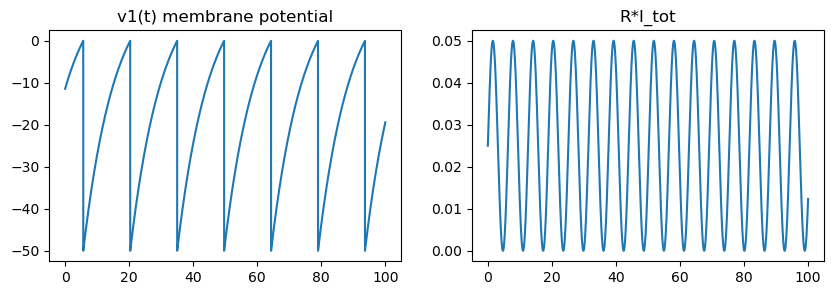

In [20]:
t_space = np.linspace(0, Tf, num = int(Tf/dt))
fig, ax = plt.subplots(1, 2, figsize = (10, 3))
ax[0].plot(t_space, voltage[0,:])
ax[0].set_title("v1(t) membrane potential")
ax[1].plot(t_space, R*i_ext(t_space*dt))
ax[1].set_title("R*I_tot")
plt.show()

2. Plot the low-pass filtered activity of the population, using a time bin of τA = 1ms. Make the corresponding raster plot.

How would the system behave as t → ∞? Why?

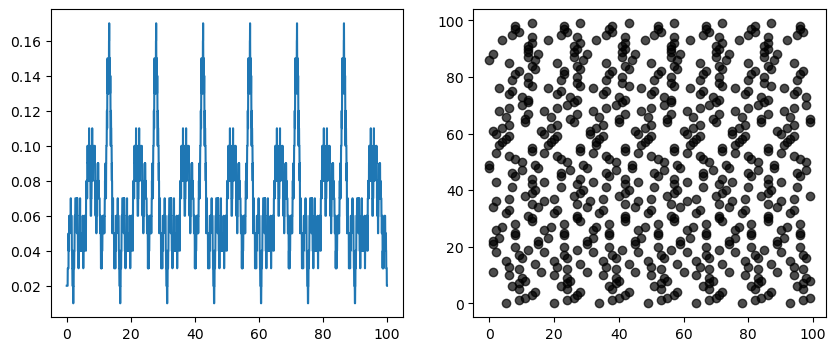

In [21]:
activity = [(1/dt) * sum(firing_times[:, k])/N for k in range(int(Tf/dt))]

ta = 100
filtered_activity = np.convolve(activity, np.ones(ta), mode='same')/ta

#for the raster plot
raster_ta = []
x_coords = []
for idx in range(100):
    neuron_idxs_firing = sum(raster[idx*ta: idx*ta + ta], [])
    raster_ta.append(neuron_idxs_firing)
    
    for n in neuron_idxs_firing:
        x_coords.append(idx)

fig, ax = plt.subplots(1,2, figsize = (10, 4))
ax[0].plot(t_space, filtered_activity)
ax[1].scatter(x_coords, [item for sublist in raster_ta for item in sublist], c = "k", alpha = 0.7)
plt.show()

## Self-interacting population

In [22]:
delta = 5 #ms 
rise_time = 2 #ms
J = 20 #mV

### Ex 1. Observation of the synchronous state

1. Implement a method that integrates numerically eqs.(4) and (5), given initial conditions vi(0), and ϵA,B(0).

In [23]:
print(eta)

0


In [29]:
import pandas as pd

def voltage_integration(vt0, eA0, eB0, Tf_, current): #euler method
    
    voltages = np.zeros((N, int(Tf_ / dt)))
    firing_times = [[]]
    kernel = pd.DataFrame({"A": np.zeros(int(Tf_/dt)), "B": np.zeros(int(Tf_/dt))})
    
    #print(kernel)
    voltages[:, 0] = np.random.uniform(v0, eta, size=N)
    #print(voltages[:,0])
    kernel.loc[0, "A"] = eA0
    kernel.loc[0, "B"] = eB0
    
    for t in range(1, int(Tf_/dt)):
        
        kernel.loc[t, "B"] = kernel.loc[t-1, "B"] + (1/rise_time) * ((len(firing_times[t-1])/N)- dt*kernel.loc[t-1, "B"])
        
        kernel.loc[t, "A"] = kernel.loc[t-1, "A"] + (1/rise_time) * (kernel.loc[t-1, "B"] - kernel.loc[t-1, "A"])
        
        update_voltage = (-1/tau_m) * ((voltages[:, t - 1] - v_rest) + R*current(t-1))# + J*kernel.iloc[t-1-int(delta/dt), 1]
        
        voltages[:, t] = voltages[:, t - 1] + dt * update_voltage
        
        #firing_neurons
        
        firing_n = np.where(voltages[:, t] >= eta)[0]
        neurons_toAdd = []
        
        for neuro in firing_n: 
            if np.random.rand() < Beta: 
                #question comment implémenter le Beta pck là il fire à tout les coups
                neurons_toAdd.append(neuro)
                voltages[:, t] = v0 #reset after spike fire to v0 (maybe vrest?)
        
        firing_times.append(neurons_toAdd)
        
    return voltages, firing_times

## Spontaneous dynamics of the system
2. Starting from the random uniform initial voltage distribution vi(0) ∼ U([v0, η]), and ϵA(0) = ϵB(0) = 0, simulate the evolution of the system for t ≤ Tf = 600ms.

    1. Make a plot of the activity (low-passed with τA = 0.5ms) and a raster plot, for the first 200ms and last 30ms of the evolution. Why is the activity composed of sharp oscillations/peaks?
    2. Compute the period T between two peaks.
    3. How would the network behave as t → ∞

### A)

In [25]:
Tf2 = 600

In [30]:
#A
v_, ft = voltage_integration(np.random.uniform(v0, eta, size=N), 0, 0, Tf2, i_ext)

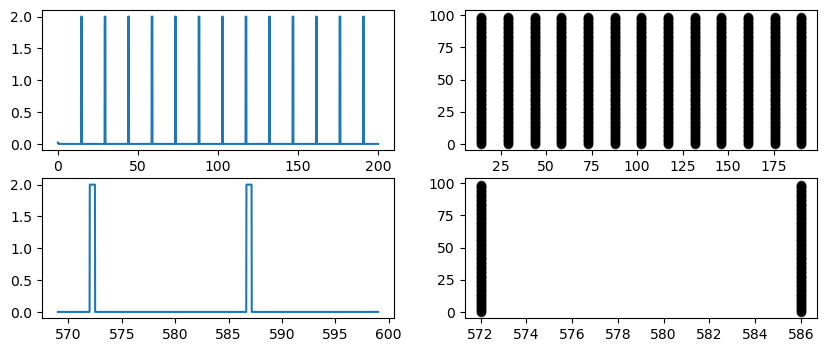

In [27]:
def plot_Q2(ft, ta_):
    t_space2= np.linspace(0, Tf2, num = int(Tf2/dt))

    activity = [(1/dt) * (len(ft[k])/N) for k in range(int(Tf2/dt))]
    filtered_activity = np.convolve(activity, np.ones(ta_), mode='same')/ta_

    raster_neurons = []
    x_coords = []
    for idx in range(Tf2):
        neuron_idxs_firing = sum(ft[idx*100: idx*100 + 100], [])
        raster_neurons.append(neuron_idxs_firing)
    
        for n in neuron_idxs_firing:
            x_coords.append(idx)
        

    time_frames = [(0, 200), (569, 599)]
    fig, ax = plt.subplots(2,2, figsize = (10, 4))

    xcoords_np = np.array(x_coords)
    raster_neurons_np = np.array([item for sublist in raster_neurons for item in sublist])

    for idx, timef in enumerate(time_frames):
    
        ax[idx, 0].plot(t_space2[int(timef[0]/dt):int(timef[1]/dt)], filtered_activity[
            int(timef[0]/dt):int(timef[1]/dt)])
    
        ax[idx, 1].scatter(xcoords_np[(xcoords_np > timef[0]) & (xcoords_np < timef[1])], raster_neurons_np[
            (xcoords_np > timef[0]) & (xcoords_np < timef[1])], c = "k", alpha = 0.7)
    plt.show()
    return x_coords
    
x_coords = plot_Q2(ft, 50)

### B)
From looking we can estimate this period between 2 peaks that its about T = 7.5ms

In [28]:
# To calculate this we can use our x_coords list which containts the times rounded up firing times
print("spike times:", x_coords[:5])
#sum all the unique values and average them by the number of spikes
fireT = np.unique(x_coords)[1:]
periods = []
for idx in range(len(fireT) - 1):
    periods.append(fireT[idx+1] - fireT[idx])

print("T =", round(np.mean(periods), 4))

spike times: [0, 14, 14, 14, 14]
T = 14.6667


### C) 
The network would continue to fire

### 3. Now consider a constant external input current Iext(t) = I0 = −0.25mA.

[  0  30  30 ... 184 184 184]


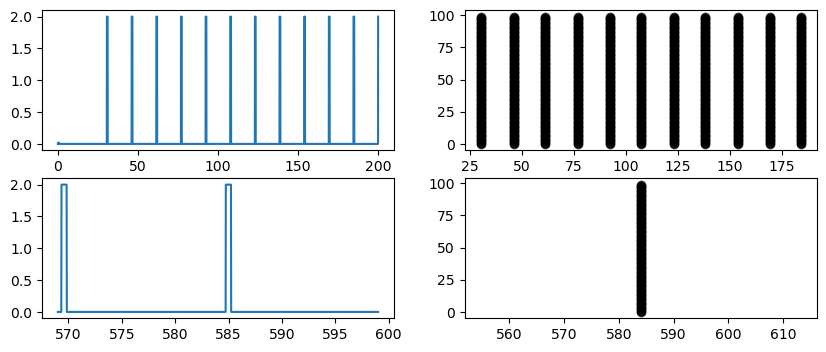

In [19]:
v_, ft = voltage_integration(np.random.uniform(v0, eta, size=N), 0, 0, Tf2, lambda t: -0.25)
x_coords = plot_Q2(ft)

In [36]:
#Slower period

2. What is the corresponding value of vrest, for which the dynamics would be the same without any external input?

Reponse: (à calculer) Loi d'ohm R*-0.25mA + ancien vrest = nouveau vrest 

## Ex 2. Transition between states

In [ ]:
def relative_firingtimes(ft_):
    return relative_ft